In [4]:
# ================================
# Environment Setup & Dependencies
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [1]:
# ====================================
# Kaggle API Configuration
# ====================================

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wesoujang","key":"5557d6f6286290a477d7c0d5ab15af1c"}'}

In [2]:
# ------------------------------------
# Move Kaggle credentials to .kaggle
# ------------------------------------

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# ==========================================
# Download NASA Turbofan Dataset from Kaggle
# ==========================================

!kaggle datasets download -d behrad3d/nasa-cmaps
!unzip -o nasa-cmaps.zip -d nasa_cmaps


Dataset URL: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
License(s): CC0-1.0
  0% 0.00/12.3M [00:00<?, ?B/s]
100% 12.3M/12.3M [00:00<00:00, 2.13GB/s]
Archive:  nasa-cmaps.zip
  inflating: nasa_cmaps/CMaps/Damage Propagation Modeling.pdf  
  inflating: nasa_cmaps/CMaps/RUL_FD001.txt  
  inflating: nasa_cmaps/CMaps/RUL_FD002.txt  
  inflating: nasa_cmaps/CMaps/RUL_FD003.txt  
  inflating: nasa_cmaps/CMaps/RUL_FD004.txt  
  inflating: nasa_cmaps/CMaps/readme.txt  
  inflating: nasa_cmaps/CMaps/test_FD001.txt  
  inflating: nasa_cmaps/CMaps/test_FD002.txt  
  inflating: nasa_cmaps/CMaps/test_FD003.txt  
  inflating: nasa_cmaps/CMaps/test_FD004.txt  
  inflating: nasa_cmaps/CMaps/train_FD001.txt  
  inflating: nasa_cmaps/CMaps/train_FD002.txt  
  inflating: nasa_cmaps/CMaps/train_FD003.txt  
  inflating: nasa_cmaps/CMaps/train_FD004.txt  
  inflating: nasa_cmaps/CMaps/x.txt  


In [5]:
# =====================================
# Define Column Names for CMAPSS Dataset
# =====================================

columns = (
    ['engine_id', 'cycle'] +
    [f'op_setting_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)


In [7]:
# ==================================
# Debug: List Current Working Folder
# ==================================

!pwd
!ls


/content
kaggle.json  nasa_cmaps  nasa-cmaps.zip  sample_data


In [8]:
# ==================================
# Debug: Search for CMAPSS Files
# ==================================

!find /content -name "train_FD001.txt"


/content/nasa_cmaps/CMaps/train_FD001.txt


In [9]:
# ==================================
# Load Turbofan Engine Data (FD001)
# ==================================

train_path = "/content/nasa_cmaps/CMaps/train_FD001.txt"

df = pd.read_csv(
    train_path,
    sep=r"\s+",
    header=None,
    names=columns
)

df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [10]:
# =====================================
# Remove Non-Informative Operating Modes
# =====================================

drop_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3']
df = df.drop(columns=drop_cols)


In [11]:
# ===============================
# Normalize Sensor Measurements
# ===============================

from sklearn.preprocessing import MinMaxScaler

sensor_cols = [c for c in df.columns if 'sensor' in c]

scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [12]:
# ======================================
# Create Sliding Window Sequences for LSTM
# ======================================

def create_sequences(df, seq_len=30):
    X, y = [], []

    for engine_id in df.engine_id.unique():
        engine_df = df[df.engine_id == engine_id]
        data = engine_df[sensor_cols].values

        for i in range(len(data) - seq_len):
            X.append(data[i:i+seq_len])
            y.append(data[i+seq_len])  # next-step prediction

    return np.array(X), np.array(y)


In [13]:
# ---------------------------
# Generate Training Sequences
# ---------------------------

SEQ_LEN = 30
X, y = create_sequences(df, SEQ_LEN)

print("Input shape:", X.shape)
print("Target shape:", y.shape)


Input shape: (17631, 30, 21)
Target shape: (17631, 21)


In [37]:
# =========================
# Define LSTM Forecast Model
# =========================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(X.shape[2])
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,381 (91.33 KB)

 Trainable params: 23,381 (91.33 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# ======================
# Train LSTM Model
# ======================

EPOCHS = 20
BATCH_SIZE = 64

history = model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2
)


Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0288 - val_loss: 0.0038
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 11/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 12/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 

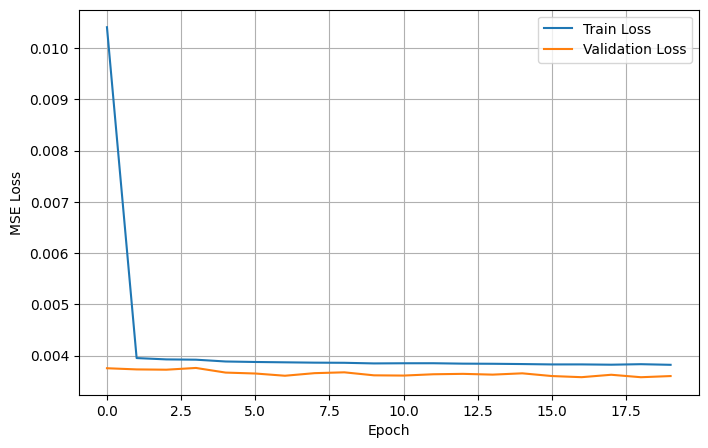

In [39]:
# =============================
# Visualize & Save Training Loss Curve
# =============================

import os

# Create directory for figures (recommended for Git)
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)

# Save before showing
plt.savefig("figures/training_loss.png", dpi=300, bbox_inches="tight")

plt.show()


551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


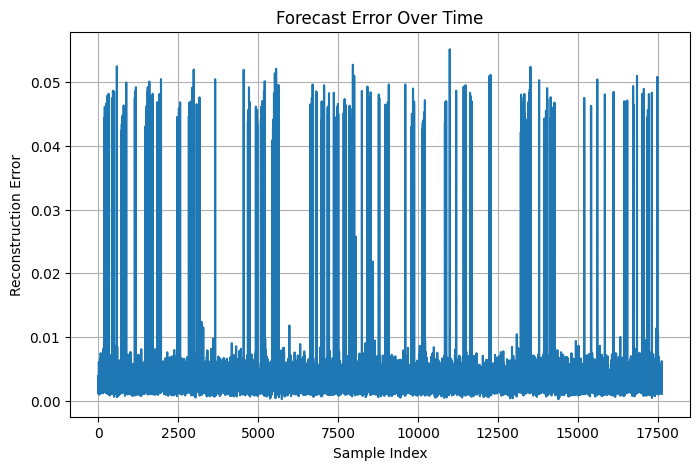

In [40]:
# ======================================
# Compute & Save Forecast Error (Anomaly Signal)
# ======================================

# Predict next-step sensor values
y_pred = model.predict(X)

# Mean squared forecast error per sequence
reconstruction_error = np.mean((y_pred - y) ** 2, axis=1)

# Ensure figures directory exists
os.makedirs("figures", exist_ok=True)

# Plot anomaly signal
plt.figure(figsize=(8, 5))
plt.plot(reconstruction_error)
plt.title("Forecast Error Over Time")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.grid(True)

# Save before showing
plt.savefig(
    "figures/forecast_error.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


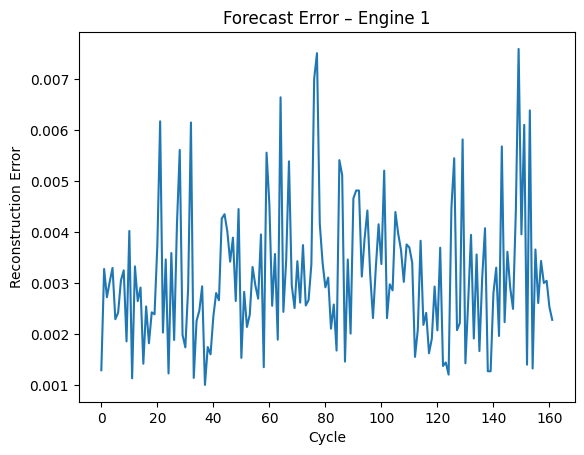

In [41]:
# ======================================
# Forecast Error (Anomaly Signal) for One Engine
# ======================================

engine_id = 1  # pick one engine

engine_df = df[df.engine_id == engine_id]
X_e, y_e = create_sequences(engine_df, SEQ_LEN)

y_pred_e = model.predict(X_e)
err_e = np.mean((y_pred_e - y_e)**2, axis=1)

plt.plot(err_e)
plt.title(f"Forecast Error – Engine {engine_id}")
plt.xlabel("Cycle")
plt.ylabel("Reconstruction Error")


# Save before showing
plt.savefig("figures/forecast_error-Engine1.png", dpi=300, bbox_inches="tight")

plt.show()


In [42]:
# ======================================
# Align Forecast Error with True RUL
# ======================================

engine_id = 1

engine_df = df[df.engine_id == engine_id].copy()
max_cycle = engine_df.cycle.max()

# True RUL
engine_df["RUL"] = max_cycle - engine_df.cycle


X_e, y_e = create_sequences(engine_df, SEQ_LEN)

y_pred_e = model.predict(X_e)
err_e = np.mean((y_pred_e - y_e) ** 2, axis=1)

# Align RUL length (sequence shift)
rul_aligned = engine_df["RUL"].values[SEQ_LEN:]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


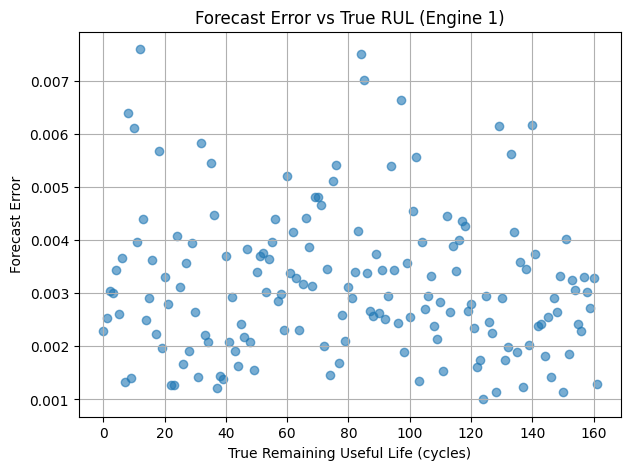

In [43]:
plt.figure(figsize=(7, 5))
plt.scatter(rul_aligned, err_e, alpha=0.6)
plt.xlabel("True Remaining Useful Life (cycles)")
plt.ylabel("Forecast Error")
plt.title("Forecast Error vs True RUL (Engine 1)")
plt.grid(True)


# Save before showing
plt.savefig("figures/forecast-error_vs_true-RUL(Engine1).png", dpi=300, bbox_inches="tight")

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


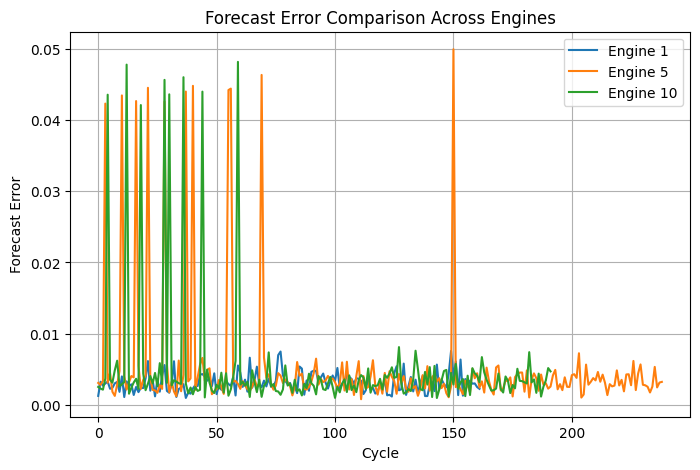

In [44]:
# ======================================
# Compare Forecast Error Across Engines
# ======================================

engine_ids = [1, 5, 10]

plt.figure(figsize=(8, 5))

for eid in engine_ids:
    edf = df[df.engine_id == eid]
    X_e, y_e = create_sequences(edf, SEQ_LEN)

    y_pred_e = model.predict(X_e)
    err_e = np.mean((y_pred_e - y_e) ** 2, axis=1)

    plt.plot(err_e, label=f"Engine {eid}")

plt.xlabel("Cycle")
plt.ylabel("Forecast Error")
plt.title("Forecast Error Comparison Across Engines")
plt.legend()
plt.grid(True)


# Save before showing
plt.savefig("figures/forecast_error_accross_Engines.png", dpi=300, bbox_inches="tight")

plt.show()


In [46]:
# ======================================
# Forecast Error with Confidence Bands
# ======================================

import pandas as pd

err_series = pd.Series(err_e)

rolling_mean = err_series.rolling(window=10).mean()
rolling_std = err_series.rolling(window=10).std()

upper = rolling_mean + 2 * rolling_std
lower = rolling_mean - 2 * rolling_std


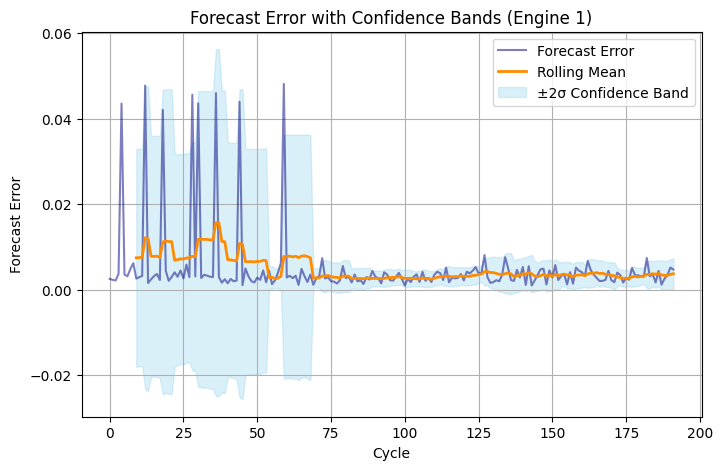

In [48]:
# ======================================
# Forecast Error with Confidence Bands
# ======================================

plt.figure(figsize=(8, 5))

# Forecast error
plt.plot(
    err_e,
    color="navy",
    alpha=0.5,
    label="Forecast Error"
)

# Rolling mean
plt.plot(
    rolling_mean,
    color="darkorange",
    linewidth=2,
    label="Rolling Mean"
)

# Confidence band
plt.fill_between(
    range(len(upper)),
    lower,
    upper,
    color="skyblue",
    alpha=0.3,
    label="±2σ Confidence Band"
)

plt.xlabel("Cycle")
plt.ylabel("Forecast Error")
plt.title("Forecast Error with Confidence Bands (Engine 1)")
plt.legend()
plt.grid(True)

plt.savefig(
    "figures/forecast_error_confidence.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [49]:
# ======================================
# Recreate LSTM Sequences WITH Aligned RUL
# ======================================

def create_sequences_with_rul(df, seq_len, sensor_cols):
    X, y, rul = [], [], []

    df = df.reset_index(drop=True).copy()
    max_cycle = df.cycle.max()
    df["RUL"] = max_cycle - df.cycle

    data = df[sensor_cols].values
    rul_values = df["RUL"].values

    for i in range(len(df) - seq_len):
        X.append(data[i : i + seq_len])
        y.append(data[i + seq_len])
        rul.append(rul_values[i + seq_len])

    return np.array(X), np.array(y), np.array(rul)


In [50]:
engine_id = 1
engine_df = df[df.engine_id == engine_id]

X_e, y_e, rul_aligned = create_sequences_with_rul(
    engine_df,
    SEQ_LEN,
    sensor_cols
)

y_pred_e = model.predict(X_e)
err_e = np.mean((y_pred_e - y_e) ** 2, axis=1)

print(len(err_e), len(rul_aligned))  # MUST match


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
162 162


In [51]:
# ======================================
# Quantify Correlation Between Error and True RUL
# ======================================

from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(err_e, rul_aligned)
spearman_corr, spearman_p = spearmanr(err_e, rul_aligned)

print(f"Pearson correlation:  {pearson_corr:.3f} (p={pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.2e})")


Pearson correlation:  -0.092 (p=2.42e-01)
Spearman correlation: -0.080 (p=3.11e-01)


In [53]:
# ======================================
# Convert Forecast Error to Health Index
# ======================================

# Normalize error to [0, 1]
err_norm = (err_e - err_e.min()) / (err_e.max() - err_e.min())

# Health Index (inverted)
health_index = 1.0 - err_norm


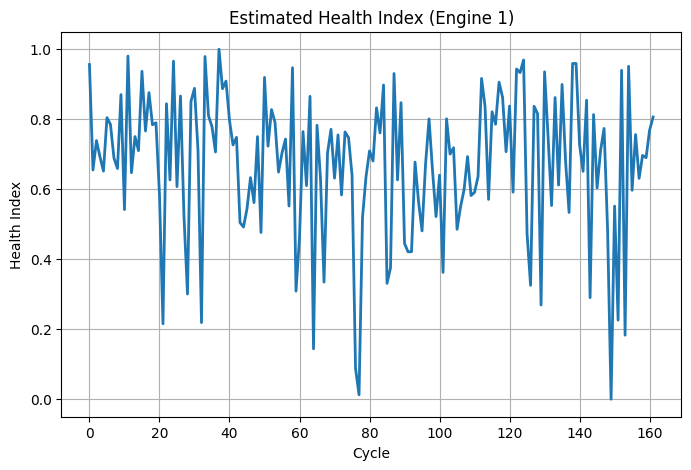

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(health_index, linewidth=2)
plt.xlabel("Cycle")
plt.ylabel("Health Index")
plt.title("Estimated Health Index (Engine 1)")
plt.grid(True)


# Save before showing
plt.savefig("figures/estimated_health_index(engine1).png", dpi=300, bbox_inches="tight")

plt.show()


In [55]:
# ======================================
# Failure Threshold Detection
# ======================================

# Define threshold using historical behavior
threshold = np.percentile(health_index, 10)  # bottom 10%

failure_cycles = np.where(health_index <= threshold)[0]

print(f"Failure threshold (HI): {threshold:.3f}")
print(f"First alarm at cycle: {failure_cycles[0] if len(failure_cycles) > 0 else 'None'}")


Failure threshold (HI): 0.380
First alarm at cycle: 21


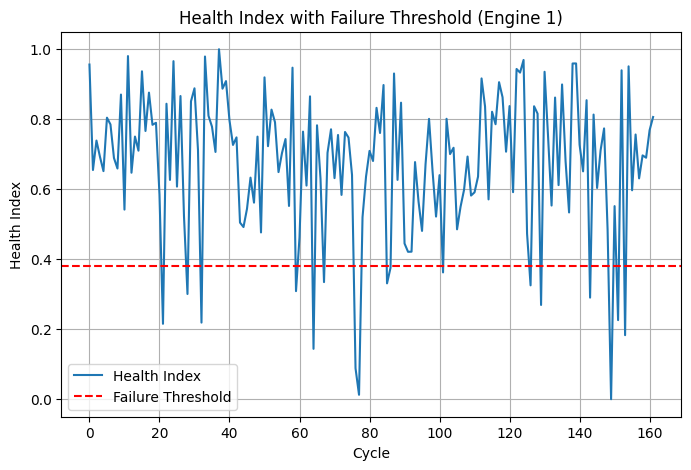

In [57]:
plt.figure(figsize=(8, 5))

plt.plot(health_index, label="Health Index")
plt.axhline(
    threshold,
    color="red",
    linestyle="--",
    label="Failure Threshold"
)

plt.xlabel("Cycle")
plt.ylabel("Health Index")
plt.title("Health Index with Failure Threshold (Engine 1)")
plt.legend()
plt.grid(True)


# Save before showing
plt.savefig("figures/health_index_failure_threshold(engine1).png", dpi=300, bbox_inches="tight")

plt.show()


Forecast error is first validated against true remaining useful life using rank correlation analysis. The error is then transformed into a bounded health index, providing an interpretable degradation metric. Finally, a statistically defined failure threshold enables early anomaly and failure detection.